## 0. Initialization

In [1]:
import torch as tc
tc.set_default_dtype(tc.float64)

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import dCl
from joblib import Parallel, delayed
import time

%load_ext autoreload
%autoreload 1
%aimport dCl

In [3]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 16,
})

In [17]:
Nz = 8
zmin = 0.3
zmax = 1.0
zmin_text = '{:.2f}'.format(zmin)
zmax_text = '{:.2f}'.format(zmax)
zend_index = 8
zlist = tc.linspace(zmin, zmax, Nz)[:zend_index]

l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])

dCl_obj = dCl.Cl_kSZ2_HI2(zlist)
Beam_HI = tc.empty([len(zlist), len(l_list)])
for zi in range(len(zlist)):
    Beam_HI[zi] = dCl_obj.Beam_HI(l_list, zindex=zi)

print('redshift from ' + zmin_text + ' to ' + zmax_text)
# params = tc.tensor(params).reshape([len(l_list)*len(pz_list), 2])

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


redshift from 0.30 to 1.00


## 0. Pre-process with the data

In [5]:
Nz = 8
zmin = 0.3
zmax = 1.0
zend_index = 8
zlist = tc.linspace(zmin, zmax, Nz)[:zend_index]
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
t1_list = tc.linspace(0., tc.pi, 60)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                    10.**tc.linspace(0, 1, 6)[:-1], 
                    tc.linspace(10, 300, 59)[:-1], 
                    10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                    10.**tc.linspace(3, 4, 10)])

In [6]:
data_total = []
for i in range(len(zlist)):
    data_i = np.load(f'./Data/Cross_z_0.30_1.00/dCl_cross_' + str(i) + '.npy') # dimensionless
    data_total.append(data_i)

np.save('./Data/Cross_z_0.30_1.00/dCl_cross.npy', np.array(data_total)) # save Cl that is dimensionless

## 1. Read in the data

### Cross-correlation

In [10]:
Nz = 8
zmin = 0.3
zmax = 1.0
zend_index = 8
zlist = tc.linspace(zmin, zmax, Nz)[:zend_index]
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
t1_list = tc.linspace(0., tc.pi, 31)
l1_list = tc.linspace(100,10000,34)

data_total = tc.tensor(np.load('./Data/Cross_z_0.30_1.00/dCl_cross.npy'))

# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor 2 for double from contribution T1 and T2
# The fourth factor (2pi)^(-5) for volume element from integral over l1 and p
# The fifth factor (2.7)^2 for recovering the dimension of kSZ effect in unit K

data_total = tc.tensor(np.array(data_total)) * 2 * 2 * 2 / (2*tc.pi)**5 * (2.7)**2

print(len(zlist), len(l_list), len(l1_list), len(t1_list))
print(data_total.shape)

8 29 34 31
torch.Size([8, 29, 34, 31])


In [11]:
########################################################################
# Evaluating the filter for kSZ
filter_ls, filter_Fl = dCl_obj.l_kSZ, dCl_obj.Fl_kSZ

ll, l1, theta1 = tc.meshgrid(l_list, l1_list, t1_list, indexing='ij')
l_m_l1_norm = tc.sqrt(ll**2 + l1**2 - 2*ll*l1*tc.cos(theta1))

Filter_kSZ = dCl.torch_interp1d(filter_ls, filter_Fl, l_m_l1_norm) * dCl.torch_interp1d(filter_ls, filter_Fl, l1)

########################################################################
# valuating the beam for HI
B_HI = tc.empty(len(zlist), len(l_list))
for iz in range(len(zlist)):
    B_HI[iz] = dCl_obj.Beam_HI(l=l_list, zindex=iz)


Filter_kSZ.shape, B_HI.shape

(torch.Size([29, 34, 31]), torch.Size([8, 29]))

In [12]:
########################################################################
# Adding filter and beam
data  = data_total * Filter_kSZ[None,:]
data *= B_HI[:,:,None,None]**2

# Adding geometric factor
data *= l1[None,:]

########################################################################
# Integrate over theta_1
data_int_t1 = tc.trapz(data, t1_list, dim=-1)

########################################################################
# Integrate over l1
data_int_l1 = tc.trapz(data_int_t1, l1_list, dim=-1)

########################################################################
# Integrate over chi
Cl_cross = tc.trapz((data_int_l1).T  * dCl_obj.F_kSZ[:zend_index]**2 * dCl_obj.G_HI[:zend_index] * dCl_obj.chi_of_z[:zend_index]**2, 
                    dCl_obj.chi_of_z[:zend_index], dim=-1)

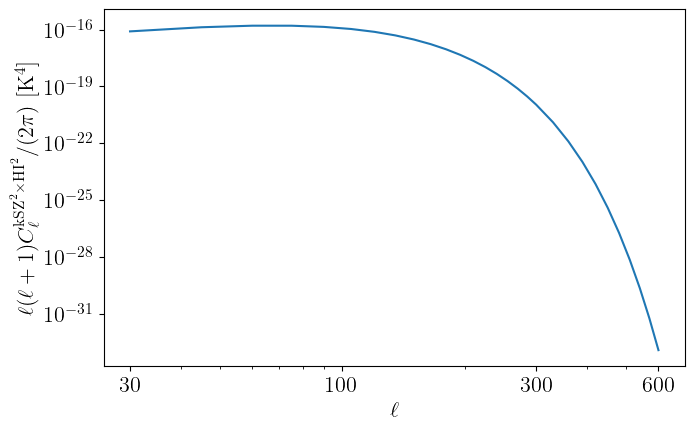

In [ ]:
fig = plt.figure(figsize=(5*1.5,3.09*1.5))
# times (2.7K)^2 to convert to temperature unit

plt.plot(l_list, l_list * (l_list + 1) * Cl_cross / (2*tc.pi), '-')

plt.xscale('log')
plt.yscale('log')

plt.xticks([30, 100, 300, 600], ['30', '100', '300', '600'])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} / (2\pi)$ [$\mathrm{K}^4$]', usetex=True)

plt.savefig('Figs/cross_correlation.pdf', bbox_inches = 'tight')
plt.show()

tensor(1.0472)
tensor(3100.)


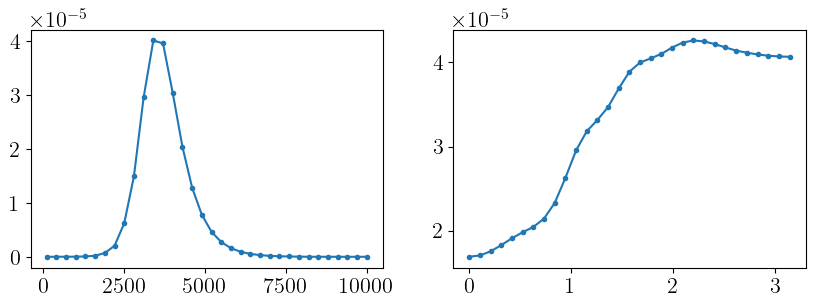

In [15]:
zi_fix = 2
li_fix = -1

fig = plt.figure(figsize=(10, 3.09))

plt.subplot(1,2,1)
ti_fix = 10
print(t1_list[ti_fix])
data_fix = data_total[zi_fix,li_fix,:,ti_fix]
Filter_fix = Filter_kSZ[li_fix,:,ti_fix]
plt.plot(l1_list, data_fix*Filter_fix, '.-')

plt.subplot(1,2,2)
l1i_fix = 10
print(l1_list[l1i_fix])
data_fix = data_total[zi_fix,li_fix,l1i_fix]
Filter_fix = Filter_kSZ[li_fix,l1i_fix]
plt.plot(t1_list, data_fix*Filter_fix, '.-')

plt.show()

### HI square field auto-correlation

In [50]:
Nz = 8
zmin = 0.3
zmax = 1.0
zend_index = 4
zlist = tc.linspace(zmin, zmax, Nz)[:zend_index]
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])

# Read in the data
# The factor 2 for double contribution from Power*Power
dCl_HI2 = 2*tc.tensor(np.load('Data/HI2_z_0.30_1.00/dCl_HI2.npy'))[:zend_index]
dCl_HI2_nobeam = 2*tc.tensor(np.load('Data/HI2_z_0.30_1.00/dCl_HI2_nobeam.npy'))[:zend_index]
dCl_HI2_nonoise = 2*tc.tensor(np.load('Data/HI2_z_0.30_1.00/dCl_HI2_nonoise.npy'))[:zend_index]
dCl_HI2_nobeam_nonoise = 2*tc.tensor(np.load('Data/HI2_z_0.30_1.00/dCl_HI2_nobeam_nonoise.npy'))[:zend_index]

# Integrate over chi
Cl_HI2 = tc.trapz((dCl_HI2).T * dCl_obj.G_HI_auto[:zend_index], dCl_obj.chi_of_z[:zend_index], dim=-1)
Cl_HI2_nobeam = tc.trapz(dCl_HI2_nobeam.T * dCl_obj.G_HI_auto[:zend_index], dCl_obj.chi_of_z[:zend_index], dim=-1)

Cl_HI2_nonoise = tc.trapz((dCl_HI2_nonoise).T * dCl_obj.G_HI_auto[:zend_index], dCl_obj.chi_of_z[:zend_index], dim=-1)
Cl_HI2_nobeam_nonoise = tc.trapz(dCl_HI2_nobeam_nonoise.T * dCl_obj.G_HI_auto[:zend_index], dCl_obj.chi_of_z[:zend_index], dim=-1)

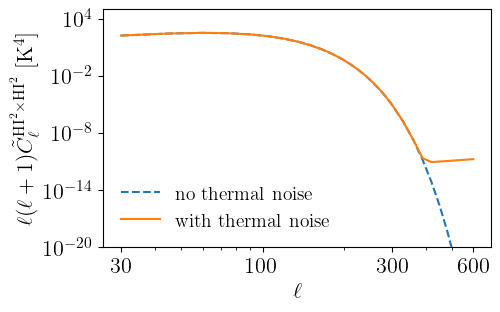

In [51]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2_nonoise, '--', label='no thermal noise')
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2, '-', label='with thermal noise')
plt.legend(fontsize=14, frameon=False)
plt.xscale('log')
plt.yscale('log')

plt.xticks([30, 100, 300, 600], ['30', '100', '300', '600'])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylim([1e-20, 1e5])
plt.ylabel(r'$\ell(\ell+1)\tilde{C}_{\ell}^{{\rm HI}^2 \times {\rm HI}^2}$ [$\mathrm{K}^4$]', usetex=True)

plt.savefig('Figs/Cl_HI2.pdf', bbox_inches = 'tight')
plt.show()

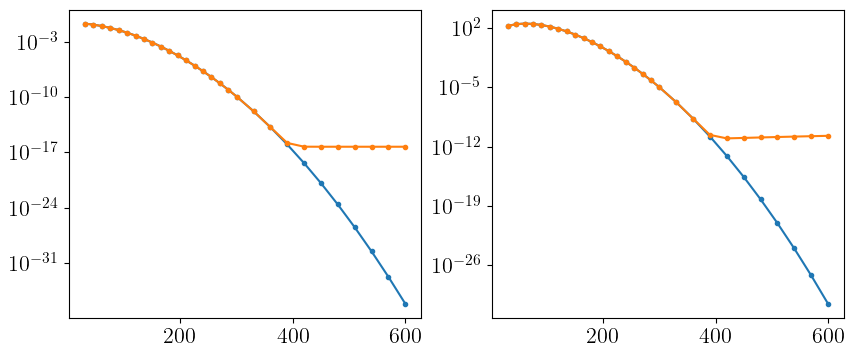

In [52]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_HI2_nonoise, '.-')
plt.plot(l_list, Cl_HI2, '.-')
# plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2_nonoise, '.-')
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2, '.-')
# plt.xscale('log')
plt.yscale('log')

plt.show()

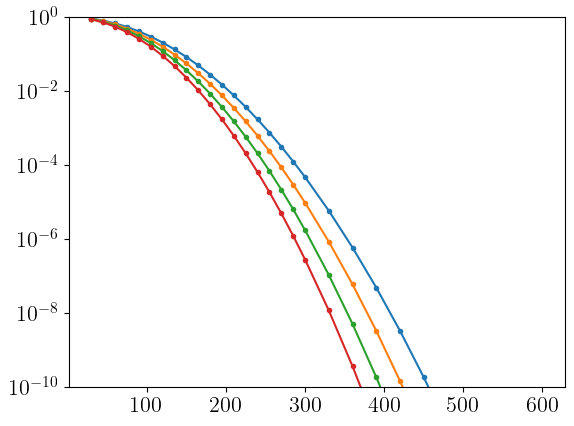

In [53]:
# Beams

for zi in range(len(zlist)):
    plt.plot(l_list, dCl_obj.Beam_HI(l_list, zindex=zi)**2, '.-')
plt.ylim([1e-10, 1])
plt.yscale('log')

plt.show()

### kSZ square field auto-correlation

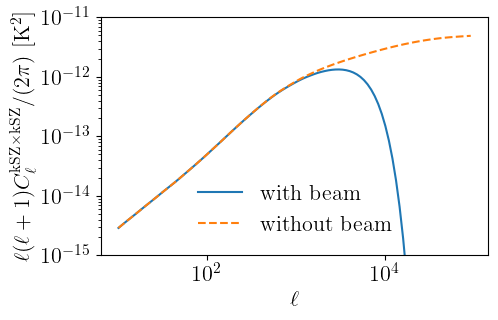

In [63]:
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))

# times (2.7K)^2 to convert to temperature unit
Cl_kSZ = tc.tensor(np.load('Data/kSZ_effect/Cl_kSZ.npy')) * (2.7)**2
Cl_kSZ_nobeam = Cl_kSZ / dCl_obj.Beam_kSZ(l_list_kSZ)**2

fig = plt.figure(figsize=(5,3.09))

xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ / (2*np.pi))[xi:xe], '-', label='with beam')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam / (2*np.pi))[xi:xe], '--', label='without beam')

plt.legend(fontsize=16, frameon=False)

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-15, 1e-11])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}} / (2\pi)$ [$\mathrm{K}^2$]', usetex=True)

# plt.savefig('Cl_kSZ.pdf', bbox_inches = 'tight')
plt.show()

In [64]:
ls_and_Fl = np.load('Data/Fl_and_l_kSZ.npy')
ls = ls_and_Fl[0]
Fl = ls_and_Fl[1]

def get_filter(l):
    return np.interp(l, ls, Fl)

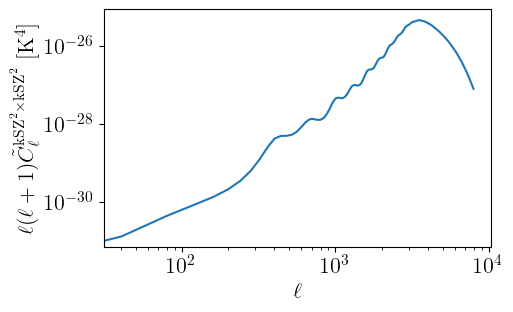

In [65]:
# The first factor (2.7)^4 for recovering the dimension of kSZ effect in unit K
# The second factor (2pi)^(-2) for volume element from integral over l1
# The third factor 2 for double contribution from Power*Power
l_list_kSZ2 = ls[::40]
CL_kSZ2 = np.load('Data/kSZ_effect/CL_kSZ2_filtered.npy') * (2.7)**4 / (2*tc.pi)**2 * 2

fig = plt.figure(figsize=(5, 3.09), dpi=100)
xi, xe = 0, -1
plt.plot(l_list_kSZ2[xi:xe], (l_list_kSZ2 * (l_list_kSZ2 + 1) * CL_kSZ2)[xi:xe], '-', label='non-linear model')
# plt.legend(fontsize=12, frameon=False)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)\tilde{C}_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$ [$\mathrm{K}^4$]', usetex=True)
# plt.ylim([1e-26, 1e-18])

plt.savefig('Figs/Cl_kSZ2.pdf', bbox_inches = 'tight')
plt.show()

## 2. SNR Estimation

In [18]:
Nz = 8
zmin = 0.3
zmax = 1.0
zend_index = 8
zlist = tc.linspace(zmin, zmax, Nz)[:zend_index]
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
t1_list = tc.linspace(0., tc.pi, 31)
l1_list = tc.linspace(100,10000,34)


def get_Cl_cross(dCl_cross, dCl_obj, l_list, l1_list, t1_list):
    ########################################################################
    # Evaluating the filter for kSZ
    filter_ls, filter_Fl = dCl_obj.l_kSZ, dCl_obj.Fl_kSZ

    ll, l1, theta1 = tc.meshgrid(l_list, l1_list, t1_list, indexing='ij')
    l_m_l1_norm = tc.sqrt(ll**2 + l1**2 - 2*ll*l1*tc.cos(theta1))

    Filter_kSZ = dCl.torch_interp1d(filter_ls, filter_Fl, l_m_l1_norm) * dCl.torch_interp1d(filter_ls, filter_Fl, l1)

    ########################################################################
    # valuating the beam for HI
    B_HI = tc.empty(len(zlist), len(l_list))
    for iz in range(len(zlist)):
        B_HI[iz] = dCl_obj.Beam_HI(l=l_list, zindex=iz)

    ########################################################################
    # Adding filter and beam
    data_total = dCl_cross * Filter_kSZ[None,:]
    data_total *= B_HI[:,:,None,None]**2

    # Adding geometric factor
    data_total *= l1[None,:]

    ########################################################################
    # Integrate over theta_1
    data_int_t1 = tc.trapz(data_total, t1_list, dim=-1)

    ########################################################################
    # Integrate over l1
    data_int_l1 = tc.trapz(data_int_t1, l1_list, dim=-1)

    ########################################################################
    # Integrate over chi
    Cl_cross = tc.trapz((data_int_l1).T  * dCl_obj.F_kSZ[:zend_index]**2 * dCl_obj.G_HI[:zend_index] * dCl_obj.chi_of_z[:zend_index]**2, 
                        dCl_obj.chi_of_z[:zend_index], dim=-1)
    
    return Cl_cross

def torch_interp1d(x, y, x_new):

    indices = tc.searchsorted(x, x_new) - 1
    indices = tc.clamp(indices, 0, len(x) - 2)

    x0, x1 = x[indices], x[indices + 1]
    y0, y1 = y[indices], y[indices + 1]

    slope = (y1 - y0) / (x1 - x0)
    y_query = y0 + slope * (x_new - x0)
    
    return y_query

def loglog_torch_itp(x, y, x_new):
    return 10**torch_interp1d(tc.log10(x), tc.log10(y), tc.log10(x_new))

In [19]:
''' 1. Get Cl_cross'''
# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor 2 for double from contribution T1 and T2
# The fourth factor (2pi)^(-5) for volume element from integral over l1 and p
# The fifth factor (2.7)^2 for recovering the dimension of kSZ effect in unit K

data_total = np.load('Data/Cross_z_0.30_1.00/dCl_cross.npy')[:zend_index] #np.array(data_total)
data_total = tc.tensor(data_total) * 2 * 2 * 2 / (2*tc.pi)**5  * (2.7)**2 # transfer into unit K^4
Cl_cross = get_Cl_cross(data_total, dCl_obj, l_list, l1_list, t1_list)

''' 2. Get Cl_HI square'''
# The factor 2 for double contribution from Power*Power
dCl_HI2 = 2*tc.tensor(np.load('Data/HI2_z_0.30_1.00/dCl_HI2.npy')) # in unit K^4
dCl_HI2_nonoise = 2*tc.tensor(np.load('Data/HI2_z_0.30_1.00/dCl_HI2_nonoise.npy')) # in unit K^4
Cl_HI2 = tc.trapz((dCl_HI2[:zend_index]).T * dCl_obj.G_HI_auto[:zend_index], dCl_obj.chi_of_z[:zend_index], dim=-1)
Cl_HI2_nonoise = tc.trapz((dCl_HI2_nonoise[:zend_index]).T * dCl_obj.G_HI_auto[:zend_index], dCl_obj.chi_of_z[:zend_index], dim=-1)

''' 3. Get Cl_kSZ square'''
l_list_kSZ2 = tc.arange(0, 8001, 1)[::40]
# The first factor (2.7)^4 for recovering the dimension of kSZ effect in unit K
# The second factor (2pi)^(-2) for volume element from integral over l1
# The third factor 2 for double contribution from Power*Power
CL_kSZ2 = tc.tensor(np.load('Data/kSZ_effect/CL_kSZ2_filtered.npy')) * (2.7)**4 / (2*tc.pi)**2 * 2 # in unit K^4


''' 4. Evaluate SNR square'''
l_list = tc.hstack([tc.linspace(30, 300, 19), tc.linspace(330, 600, 10)])
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
l30_600 = tc.arange(30, 600)


In [20]:
def loglog_itp_n(x, y, x_new, order=2):
    return 10**(interp1d(tc.log10(x), tc.log10(y), kind=order)(tc.log10(x_new)))

def linear_itp_n(x, y, x_new, order=1):
    return interp1d(x, y, kind=order)(x_new)

Cl_kSZ2_HI2 = loglog_itp_n(l_list, Cl_cross, l_list)
Cl_HI2_auto = loglog_itp_n(l_list, Cl_HI2, l_list)
Cl_HI2_nonoise_auto = loglog_itp_n(l_list, Cl_HI2_nonoise, l_list)
Cl_kSZ2_auto = linear_itp_n(l_list_kSZ2, CL_kSZ2, l_list)

In [21]:
fsky = 8000. / 40000.
SNR_coarse = fsky * (2 * l_list + 1) * Cl_kSZ2_HI2**2 / (Cl_kSZ2_HI2**2 + Cl_HI2_auto * Cl_kSZ2_auto)
SNR_coarse_nonoise = fsky * (2 * l_list + 1) * Cl_kSZ2_HI2**2 / (Cl_kSZ2_HI2**2 + Cl_HI2_nonoise_auto * Cl_kSZ2_auto)

l30_600 = tc.arange(30, 600)
SNR = tc.tensor(loglog_itp_n(l_list, SNR_coarse, l30_600))
SNR_nonoise = tc.tensor(loglog_itp_n(l_list, SNR_coarse_nonoise, l30_600))
SNR_cs = tc.cumsum(SNR, dim=0)
SNR_nonoise_cs = tc.cumsum(SNR_nonoise, dim=0)

SNR.shape, SNR_cs.shape

(torch.Size([570]), torch.Size([570]))

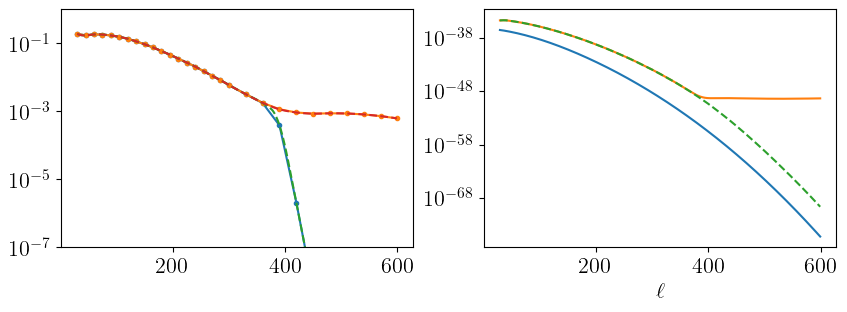

In [22]:
Cl_kSZ2_HI2 = loglog_itp_n(l_list, Cl_cross, l30_600)
Cl_HI2_auto = loglog_itp_n(l_list, Cl_HI2, l30_600)
Cl_HI2_nonoise_auto = loglog_itp_n(l_list, Cl_HI2_nonoise, l30_600)
Cl_kSZ2_auto = linear_itp_n(l_list_kSZ2, CL_kSZ2, l30_600)

fig = plt.figure(figsize=(10, 3.09))

plt.subplot(1,2,1)
plt.plot(l_list, SNR_coarse, '.-')
plt.plot(l_list, SNR_coarse_nonoise, '.-')
plt.plot(l30_600, SNR, '--')
plt.plot(l30_600, SNR_nonoise, '--')
# plt.plot(l30_330, SNR1)
# plt.plot(l330_600, SNR2)
plt.yscale('log')

# plt.xlim([20,400])
plt.ylim([1e-7,1e0])

plt.subplot(1,2,2)
plt.plot(l30_600, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_600, Cl_HI2_auto * Cl_kSZ2_auto, label = r'$\tilde{C}_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} \tilde{C}_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.plot(l30_600, Cl_HI2_nonoise_auto * Cl_kSZ2_auto, '--',
        label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
# plt.legend()
# plt.xscale('log')
plt.yscale('log')
# plt.ylim([1e-60, 1e-29])
plt.xlabel(r'$\ell$', usetex=True)
# plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)

# plt.plot(l_list, dCl_obj.Beam_HI(l_list, zindex=0, use_mean=True)**2, '.-')
# plt.yscale('log')

plt.show()

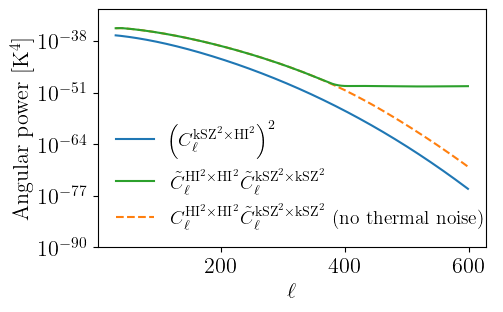

In [23]:
Cl_kSZ2_HI2 = loglog_itp_n(l_list, Cl_cross, l30_600)
Cl_HI2_auto = loglog_itp_n(l_list, Cl_HI2, l30_600)
Cl_HI2_nonoise_auto = loglog_itp_n(l_list, Cl_HI2_nonoise, l30_600)
Cl_kSZ2_auto = linear_itp_n(l_list_kSZ2, CL_kSZ2, l30_600)

fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(l30_600, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_600, Cl_HI2_nonoise_auto * Cl_kSZ2_auto, '--', 
        label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} \tilde{C}_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$ (no thermal noise)')
plt.plot(l30_600, Cl_HI2_auto * Cl_kSZ2_auto, 
        label = r'$\tilde{C}_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} \tilde{C}_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order] , fontsize=14, frameon=False)
# plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-90, 1e-30])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'Angular power [$\mathrm{K}^4$]', usetex=True)

plt.savefig('Figs/comparison.pdf', bbox_inches = 'tight')
plt.show()

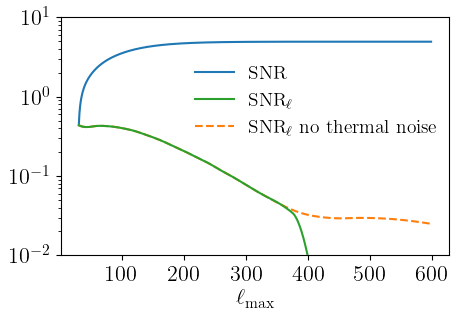

In [26]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(l30_600, np.sqrt(SNR_cs), label = r'$\mathrm{SNR}$')
plt.plot(l30_600, np.sqrt(SNR_nonoise), '--', label = r'$\mathrm{SNR}_{\ell}$ no thermal noise')
plt.plot(l30_600, np.sqrt(SNR), label = r'$\mathrm{SNR}_{\ell}$')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order] , fontsize=14, frameon=False, bbox_to_anchor=(0.3,0.65))

# plt.xscale('log')
plt.yscale('log')
# plt.yticks([0.3,1,3,6], [0.3,1.0,3.0,6.0])
plt.ylim([1e-2, 1e1])
plt.xticks([100, 200, 300, 400, 500, 600], [100, 200, 300, 400, 500, 600])

plt.xlabel(r'$\ell_{\mathrm{max}}$', usetex=True)

plt.savefig('Figs/SNR.pdf', bbox_inches = 'tight')
plt.show()

In [25]:
np.sqrt(SNR_cs[-1])

tensor(4.9444)

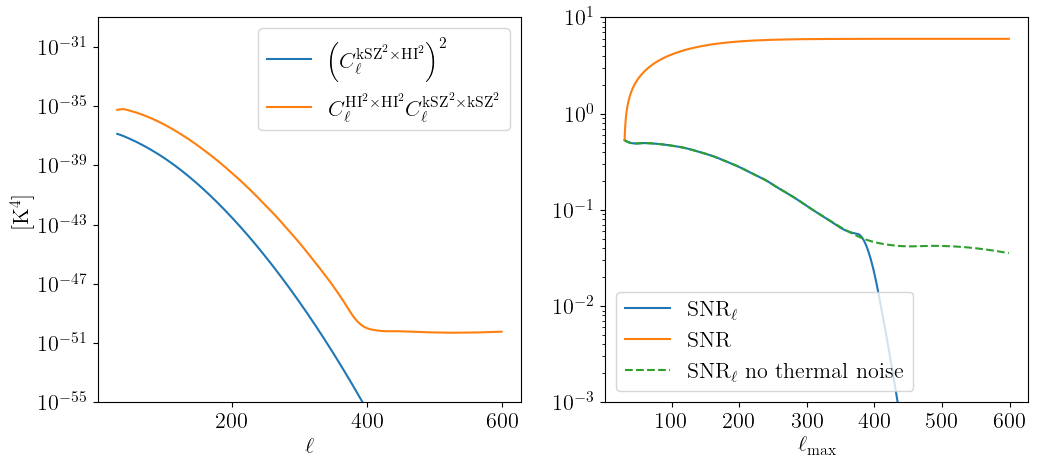

In [62]:
# With all beams
fig = plt.figure(figsize=(12,5))

####################################################################
plt.subplot(1,2,1)
plt.plot(l30_600, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_600, Cl_HI2_auto * Cl_kSZ2_auto, label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-55, 1e-29])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)

####################################################################
plt.subplot(1,2,2)
plt.plot(l30_600, np.sqrt(SNR), label = r'$\mathrm{SNR}_{\ell}$')
plt.plot(l30_600, np.sqrt(SNR_cs), label = r'$\mathrm{SNR}$')
plt.plot(l30_600, np.sqrt(SNR_nonoise), '--', label = r'$\mathrm{SNR}_{\ell}$ no thermal noise')
plt.legend()
plt.yscale('log')
# plt.yticks([0.3,1,3,6], [0.3,1.0,3.0,6.0])
plt.ylim([1e-3, 10])
plt.xticks([100, 200, 300, 400, 500, 600], [100, 200, 300, 400, 500, 600])
plt.xlabel(r'$\ell_{\mathrm{max}}$', usetex=True)

####################################################################
# plt.savefig('Figs/SNR2.pdf', bbox_inches = 'tight')
plt.show()